C:\Users\NeilXu\AppData\Local\Temp\ipykernel_19348\3922752373.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers_df['gender'].fillna('unknown', inplace=True)
C:\Users\NeilXu\AppData\Local\Temp\ipykernel_19348\3922752373.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

Accuracy: 0.8305
Precision: 0.8320298607992815
Recall: 0.8305
F1 Score: 0.8311633394936069
ROC AUC Score: 0.9494231936803974


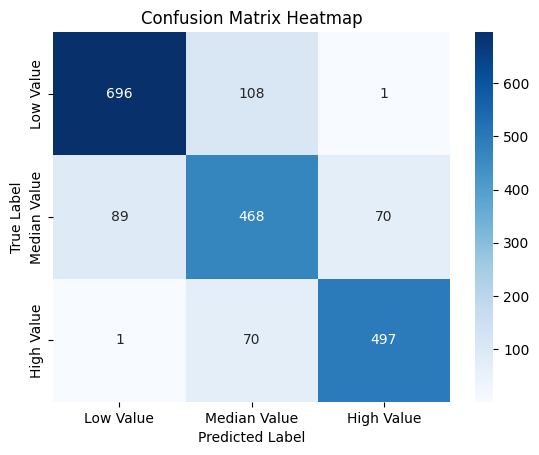

In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
customers_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

# Data Cleaning
# Convert date columns to datetime
customers_df['join_date'] = pd.to_datetime(customers_df['join_date'])
customers_df['last_purchase_date'] = pd.to_datetime(customers_df['last_purchase_date'])
marketing_df['campaign_date'] = pd.to_datetime(marketing_df['campaign_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

# Convert dates later than 7/17/2024 to 7/17/2024
cutoff_date = pd.Timestamp('2024-07-17')
customers_df['join_date'] = customers_df['join_date'].apply(lambda x: min(x, cutoff_date))
customers_df['last_purchase_date'] = customers_df['last_purchase_date'].apply(lambda x: min(x, cutoff_date))
marketing_df['campaign_date'] = marketing_df['campaign_date'].apply(lambda x: min(x, cutoff_date))
transactions_df['transaction_date'] = transactions_df['transaction_date'].apply(lambda x: min(x, cutoff_date))

# Impute 'unknown' for missing gender values
customers_df['gender'].fillna('unknown', inplace=True)

# Impute missing values in the Customers dataset using KNN for 'age'
imputer = KNNImputer(n_neighbors=5)
customers_df[['age']] = imputer.fit_transform(customers_df[['age']])

# Feature Engineering
# Calculate Recency, Frequency, and Monetary Value (RFM) features
rfm = transactions_df.groupby('customer_id').agg({
    'transaction_date': lambda x: (cutoff_date - x.max()).days,
    'transaction_id': 'count',
    'transaction_amount': 'sum'
}).reset_index()
rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Calculate the number of months from join date to last purchase date
customers_df['months_since_join'] = (customers_df['last_purchase_date'] - customers_df['join_date']).dt.days / 30
customers_df['months_since_join'].replace(0, 1, inplace=True)  # Avoid division by zero
customers_df['months_since_join'] = customers_df['months_since_join'].apply(lambda x: x if x > 1 else 1)

# Define CLV using the new formula
rfm['clv'] = rfm['monetary'] / customers_df['months_since_join']

# Merge RFM data with Customers data
merged_df = customers_df.merge(rfm, on='customer_id', how='left')

# Merge with Engagements data
merged_df = merged_df.merge(engagements_df, on='customer_id', how='left')

# Calculate the number of total responses to marketing campaigns
total_responses = marketing_df.groupby('customer_id').size().reset_index(name='total_responses')

# Merge with the Marketing data
merged_df = merged_df.merge(total_responses, on='customer_id', how='left')
merged_df['total_responses'].fillna(0, inplace=True)

# Calculate the number of positive responses to marketing campaigns
positive_responses_count = marketing_df[marketing_df['response'] == 'Yes'].groupby('customer_id').size().reset_index(name='positive_responses')

# Merge with the positive responses data
merged_df = merged_df.merge(positive_responses_count, on='customer_id', how='left')
merged_df['positive_responses'].fillna(0, inplace=True)

# Feature Engineering for Engagements
# Replace 0 with 1 to avoid division by zero in frequency
merged_df['frequency'].replace(0, 1, inplace=True)

# Calculate positive responses per transaction, emails opened per transaction, clicks per transaction, and site visits per transaction
merged_df['positive_responses_per_transaction'] = merged_df['positive_responses'] / merged_df['frequency']
merged_df['emails_opened_per_transaction'] = merged_df['number_of_emails_opened'] / merged_df['frequency']
merged_df['clicks_per_transaction'] = merged_df['number_of_clicks'] / merged_df['frequency']
merged_df['site_visits_per_transaction'] = merged_df['number_of_site_visits'] / merged_df['frequency']

# Replace any remaining infinite values with NaN and drop rows with NaN in features
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(subset=['positive_responses_per_transaction', 'emails_opened_per_transaction', 'clicks_per_transaction', 'site_visits_per_transaction'], inplace=True)

# Sort customers by CLV and calculate cumulative CLV
merged_df = merged_df.sort_values(by='clv', ascending=False)
merged_df['cumulative_clv'] = merged_df['clv'].cumsum()
total_clv = merged_df['clv'].sum()

# Label customers as 'high value', 'median value' or 'low value'
merged_df['CLV_label'] = np.where(merged_df['cumulative_clv'] <= 0.8 * total_clv, 'High Value', 
                                  np.where(merged_df['cumulative_clv'] <= 0.95 * total_clv, 'Median Value', 'Low Value'))

# Convert CLV_label to numeric
label_mapping = {'Low Value': 0, 'Median Value': 1, 'High Value': 2}
merged_df['CLV_label'] = merged_df['CLV_label'].map(label_mapping)

# Select features and target variable for random forest
features = ['age', 'recency', 'frequency', 
            'positive_responses_per_transaction', 'emails_opened_per_transaction', 
            'clicks_per_transaction', 'site_visits_per_transaction', 'gender']
X = merged_df[features]
y = merged_df['CLV_label']

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['gender'], drop_first=True)

# Check for any remaining missing values in the data
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

# Align X and y to ensure the same rows
X = X.loc[y.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Value', 'Median Value', 'High Value'], yticklabels=['Low Value', 'Median Value', 'High Value'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


Cohen's Kappa: 0.7431432896752694
Matthews Correlation Coefficient: 0.7432454249431106
Log Loss: 0.4217063127455034
Feature Importance:
                              Feature  Importance
5              clicks_per_transaction    0.261153
4       emails_opened_per_transaction    0.259592
6         site_visits_per_transaction    0.249784
2                           frequency    0.066549
1                             recency    0.061161
0                                 age    0.044969
3  positive_responses_per_transaction    0.044577
7                         gender_Male    0.008973
8                      gender_unknown    0.003242


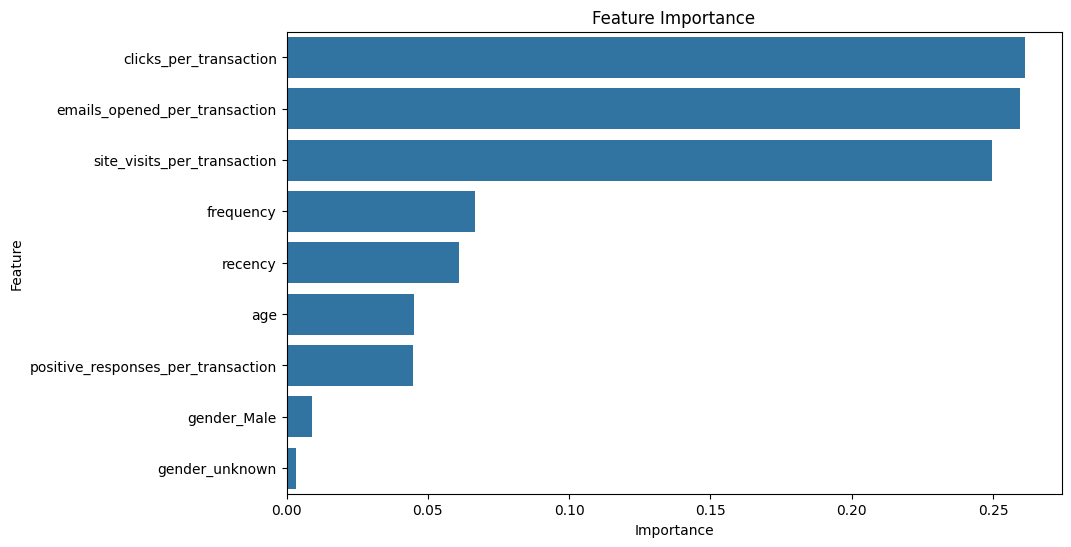

In [6]:
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, log_loss

# Calculate additional metrics
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_prob)

# Feature importance
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(f"Cohen's Kappa: {kappa}")
print(f"Matthews Correlation Coefficient: {mcc}")
print(f"Log Loss: {log_loss_value}")

# Display feature importance
print("Feature Importance:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [7]:
# Check the imbalance
# Calculate the distribution of the target variable
class_distribution = merged_df['CLV_label'].value_counts(normalize=True)

# Print the class distribution
print(class_distribution)

CLV_label
0    0.4017
1    0.3138
2    0.2845
Name: proportion, dtype: float64


In [8]:
merged_df

,customer_id,join_date,last_purchase_date,age,gender,location,months_since_join,recency,frequency,monetary,...,number_of_emails_opened,number_of_clicks,total_responses,positive_responses,positive_responses_per_transaction,emails_opened_per_transaction,clicks_per_transaction,site_visits_per_transaction,cumulative_clv,CLV_label
7015,7016,2024-05-14,2024-05-28,45.000000,unknown,West Karifort,1.000000,51,25,22364.72,...,1,1,1,0.0,0.000000,0.040000,0.040000,0.24,2.236472e+04,2
6632,6633,2024-05-25,2024-05-28,54.000000,Male,Anthonymouth,1.000000,51,25,21518.15,...,1,1,3,0.0,0.000000,0.040000,0.040000,0.04,4.388287e+04,2
7583,7584,2024-04-20,2024-05-12,24.000000,Female,Elizabethton,1.000000,67,25,21056.06,...,1,1,2,1.0,0.040000,0.040000,0.040000,0.04,6.493893e+04,2
3822,3823,2022-11-29,2022-12-29,60.000000,Male,Monicaburgh,1.000000,569,22,20601.69,...,1,2,4,3.0,0.136364,0.045455,0.090909,0.50,8.554062e+04,2
1916,1917,2024-01-01,2024-01-01,28.000000,Male,South Crystalland,1.000000,198,25,19876.28,...,1,1,2,1.0,0.040000,0.040000,0.040000,0.04,1.054169e+05,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729,1730,2021-03-21,2023-12-29,39.000000,Male,Rachelton,33.766667,792,1,46.66,...,46,73,3,2.0,2.000000,46.000000,73.000000,93.00,1.878661e+07,0
9538,9539,2020-09-21,2024-05-28,41.000000,Male,Annatown,44.833333,1393,1,59.64,...,164,18,4,1.0,1.000000,164.000000,18.000000,233.00,1.878661e+07,0
5414,5415,2020-08-07,2023-06-17,43.467467,Female,Michaelberg,34.800000,1027,1,29.11,...,193,10,1,1.0,1.000000,193.000000,10.000000,160.00,1.878661e+07,0
5866,5867,2020-07-02,2024-01-05,63.000000,Female,Port Danielleside,42.733333,956,1,29.92,...,234,34,3,0.0,0.000000,234.000000,34.000000,578.00,1.878661e+07,0
